# Time-series forecasting - breastfeeding

Project:
Using feeding data manually input into Baby Tracker app over a period of ~8 months (Feb 15th to 3rd Oct - baby's age: 1 month old to 9 months old).

Hypothesis:
Amount of time spent feeding (breast and/or bottle) decreases as baby ages and becomes a more efficient feeder. Time spent at breast/bottle reduces even further as weaning to solid foods begins around 6 months (weaning began on 20th July). Time spend consuming solid food(s) not captured by data.

Aim:
Model(s) to predict how much time baby would spend feeding (breast/bottle) from age 8 months to age 12 months, with the assumption that baby will then naturally transition from formula/breast feeds to just consuming solid foods at around 12 months of age

Notebook includes: -Data loading / manipulation, Creating lag plots, Decomposing time-series data, Differencing, Test train split, Persistence model, Auto regression (TBC), Moving average model, ARIMA. Please note not all models are suitable for this dataset but were attempted for learning and development purposes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import datetime

In [2]:
plt.rcParams['figure.figsize'] = [16,8]
# adjusts the size of all plots in notebook

In [3]:
# download breastfeeding_data csv file from folder
df = pd.read_csv('breastfeeding_dataset.csv', header=0)

In [4]:
df.head()

,RecordCategory,RecordSubCategory,StartDate,FinishDate
0,Feeding,Left Breast,Feb-15-2022 01:58,Feb-15-2022 02:19
1,Feeding,Right Breast,Feb-15-2022 02:19,Feb-15-2022 02:32
2,Feeding,Left Breast,Feb-15-2022 04:21,Feb-15-2022 04:34
3,Feeding,Right Breast,Feb-15-2022 04:35,Feb-15-2022 04:47
4,Feeding,Right Breast,Feb-15-2022 04:49,Feb-15-2022 05:25


In [5]:
# convert StartDate and FinishDate to datetime
df['StartDate'] = pd.to_datetime(df['StartDate'], errors='coerce')
df['FinishDate'] = pd.to_datetime(df['FinishDate'], errors='coerce')

In [6]:
# convert total time breastfeeding from yyyy/mm/dd hh/mm/ss to minutes
df['TotalTime'] = (df['FinishDate'] - df['StartDate']).dt.total_seconds() / 60

In [7]:
df.head()

,RecordCategory,RecordSubCategory,StartDate,FinishDate,TotalTime
0,Feeding,Left Breast,2022-02-15 01:58:00,2022-02-15 02:19:00,21.0
1,Feeding,Right Breast,2022-02-15 02:19:00,2022-02-15 02:32:00,13.0
2,Feeding,Left Breast,2022-02-15 04:21:00,2022-02-15 04:34:00,13.0
3,Feeding,Right Breast,2022-02-15 04:35:00,2022-02-15 04:47:00,12.0
4,Feeding,Right Breast,2022-02-15 04:49:00,2022-02-15 05:25:00,36.0


In [8]:
# separating out date and time
df["Date"] = df["StartDate"].dt.date
df["Time"] = df["StartDate"].dt.time

In [9]:
#converting Total Time to int (rather than decimal)
df['TotalTime'] = df['TotalTime'].apply(np.int64)

In [10]:
df['TotalTime'].dtype

dtype('int64')

In [11]:
df.head()

,RecordCategory,RecordSubCategory,StartDate,FinishDate,TotalTime,Date,Time
0,Feeding,Left Breast,2022-02-15 01:58:00,2022-02-15 02:19:00,21,2022-02-15,01:58:00
1,Feeding,Right Breast,2022-02-15 02:19:00,2022-02-15 02:32:00,13,2022-02-15,02:19:00
2,Feeding,Left Breast,2022-02-15 04:21:00,2022-02-15 04:34:00,13,2022-02-15,04:21:00
3,Feeding,Right Breast,2022-02-15 04:35:00,2022-02-15 04:47:00,12,2022-02-15,04:35:00
4,Feeding,Right Breast,2022-02-15 04:49:00,2022-02-15 05:25:00,36,2022-02-15,04:49:00


In [12]:
# ensuring Date is in datetime format
df['Date'] = pd.to_datetime(df['Date']).astype('datetime64[ns]')

In [13]:
#check datatypes for all columns
df.dtypes

RecordCategory               object
RecordSubCategory            object
StartDate            datetime64[ns]
FinishDate           datetime64[ns]
TotalTime                     int64
Date                 datetime64[ns]
Time                         object
dtype: object

In [14]:
# grouping total time breastfeeding to show total time per day (in minutes) - grouping on Date
df2 = df.groupby(['Date']).sum()

In [15]:
df2.head(231)

,TotalTime
Date,
2022-02-15,492
2022-02-16,461
2022-02-17,310
2022-02-18,344
2022-02-19,345
...,...
2022-09-29,58
2022-09-30,51
2022-10-01,47


<AxesSubplot:xlabel='Date'>

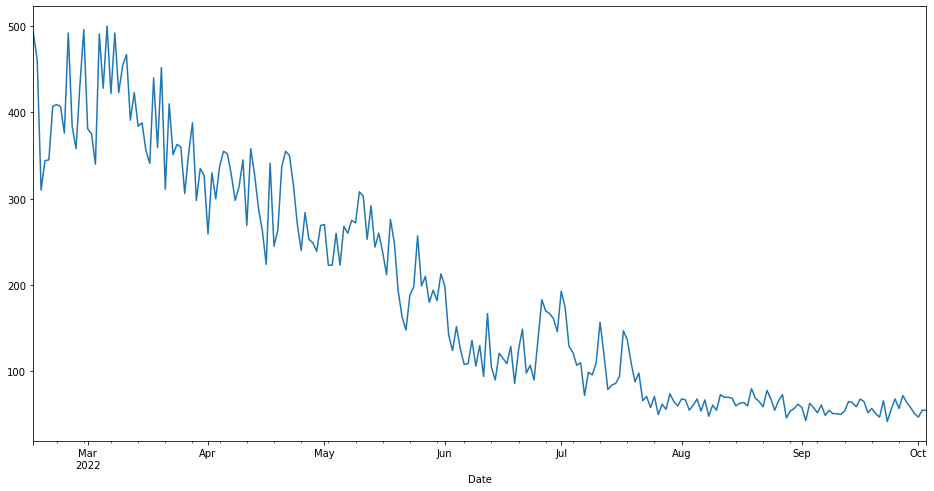

In [16]:
# matplotlib to visualise total time breastfeeding (in minutes) per day between 15th Feb 2022 and 3rd Oct 2022
# clear reduction in time spent feeding over time - from 7-8hours at 1 month post-birth to 45-1hr at 8 months of age
# suggests an increased efficiency in breastfeeding. Note weaning to solid foods begins 20th July 2022
# spikes in feeding may suggest a growth spurt / developmental need for more milk?
df2['TotalTime'].plot()

In [17]:
# can't use datetime in seaborn to do a scatterplot so create new column 'day' to use as integer for x axis
df3 = df2.groupby(['Date']).sum()

In [18]:
df3.head()

,TotalTime
Date,
2022-02-15,492
2022-02-16,461
2022-02-17,310
2022-02-18,344
2022-02-19,345


In [19]:
# df3 creating new column ('day') from 0 to end of dataset (continuous numbers) to use as index column (integer)
df3['day'] = range(0, 0+len(df3))

In [20]:
df3.head()

,TotalTime,day
Date,,
2022-02-15,492,0
2022-02-16,461,1
2022-02-17,310,2
2022-02-18,344,3
2022-02-19,345,4


In [21]:
# set 'day' as index
df3.set_index('day')

,TotalTime
day,
0,492
1,461
2,310
3,344
4,345
...,...
226,58
227,51
228,47


In [22]:
# confirm datatype are int for 'Total Time' and 'day'
df3['TotalTime'].dtype

dtype('int64')

In [23]:
df3['day'].dtype

dtype('int64')

<AxesSubplot:xlabel='day', ylabel='TotalTime'>

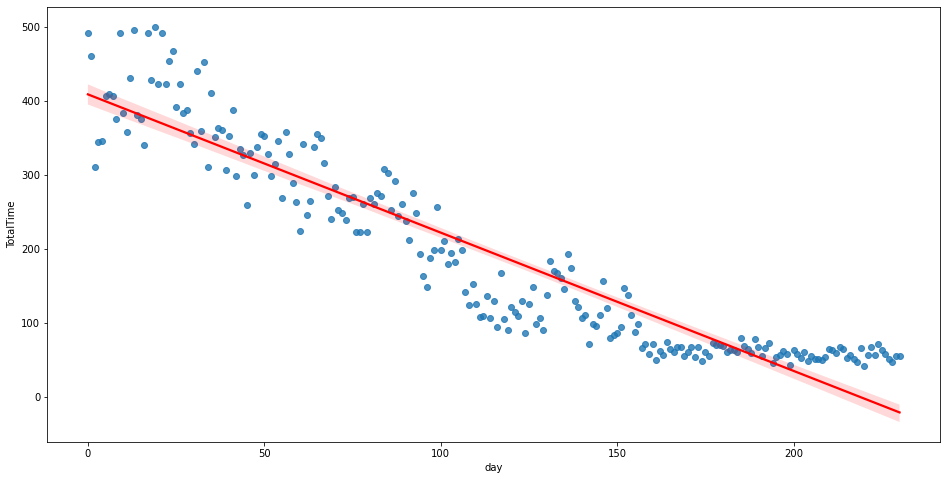

In [116]:
# trendline going down / negative slope = negative trend in data
# time spent breastfeeding is decreasing over time
sns.regplot(x= df3['day'], y=df3['TotalTime'], line_kws={"color": "red"})

<AxesSubplot:xlabel='day', ylabel='TotalTime'>

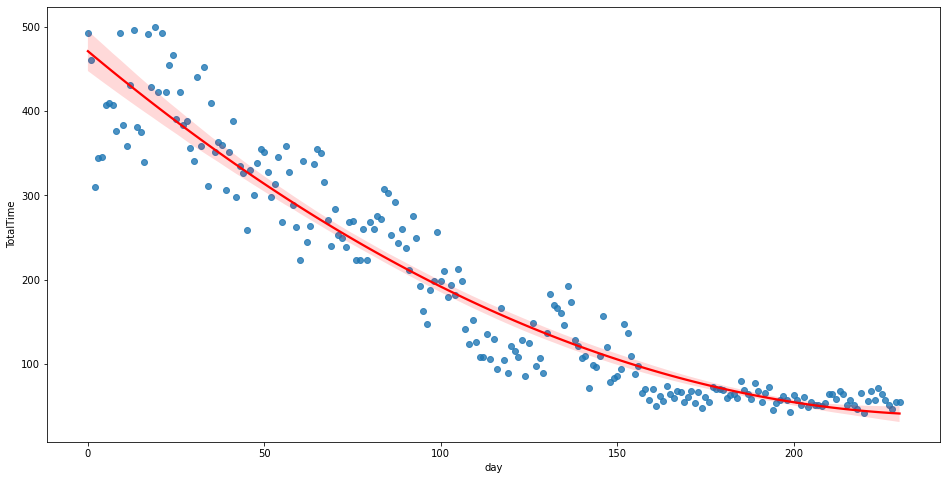

In [118]:
# quadratic trendline
# shows negative slope that is beginning to plateau from ~day 180 onwards (approx 6 months)
sns.regplot(x= df3['day'], y=df3['TotalTime'], order=2, line_kws={"color": "red"})

# Creating Lag Plots

In [26]:
# lag shifts 1 
df['lag_1'] = df['TotalTime'].shift(1)

In [27]:
df.head()

,RecordCategory,RecordSubCategory,StartDate,FinishDate,TotalTime,Date,Time,lag_1
0,Feeding,Left Breast,2022-02-15 01:58:00,2022-02-15 02:19:00,21,2022-02-15,01:58:00,NaN
1,Feeding,Right Breast,2022-02-15 02:19:00,2022-02-15 02:32:00,13,2022-02-15,02:19:00,21.0
2,Feeding,Left Breast,2022-02-15 04:21:00,2022-02-15 04:34:00,13,2022-02-15,04:21:00,13.0
3,Feeding,Right Breast,2022-02-15 04:35:00,2022-02-15 04:47:00,12,2022-02-15,04:35:00,13.0
4,Feeding,Right Breast,2022-02-15 04:49:00,2022-02-15 05:25:00,36,2022-02-15,04:49:00,12.0


<AxesSubplot:xlabel='lag_1', ylabel='TotalTime'>

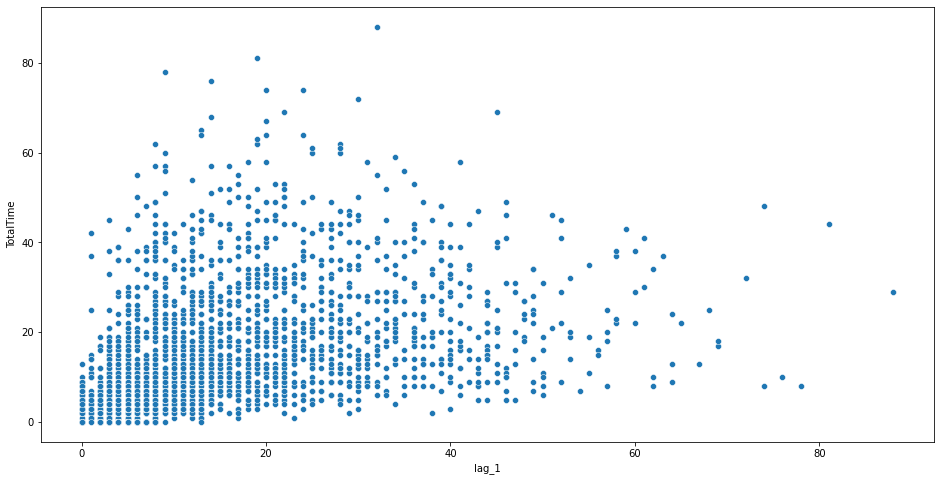

In [28]:
# some positive correlation (if lag_1 value is high, Total Time is generally high)
sns.scatterplot(x= df['lag_1'], y=df['TotalTime'])

In [29]:
# autocorrelation plot
from pandas.plotting import autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

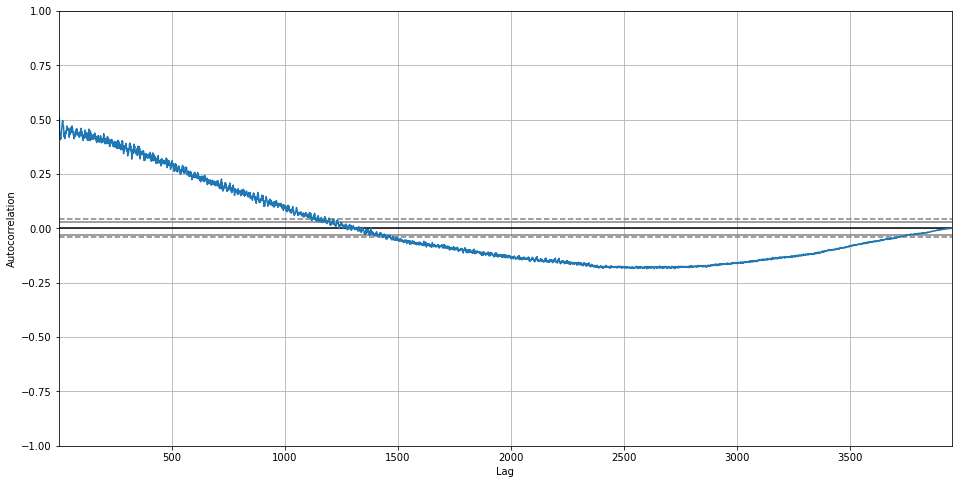

In [30]:
# graph shows high correlation between first few values (around 0.50) - lag values correlated with Total Time
# then drop in correlation from approx lag 1300
# suggests data is not seasonal

autocorrelation_plot(df['TotalTime'])

# Decomposing time-series data

level + trend + seasonality + noise

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [32]:
# create new dataframe called decomp_df (making a copy of df3)
decomp_df = df3.copy()

In [33]:
decomp_df.head()

,TotalTime,day
Date,,
2022-02-15,492,0
2022-02-16,461,1
2022-02-17,310,2
2022-02-18,344,3
2022-02-19,345,4


In [34]:
# creating an additive model
result = seasonal_decompose(decomp_df['TotalTime'], model = 'additive')

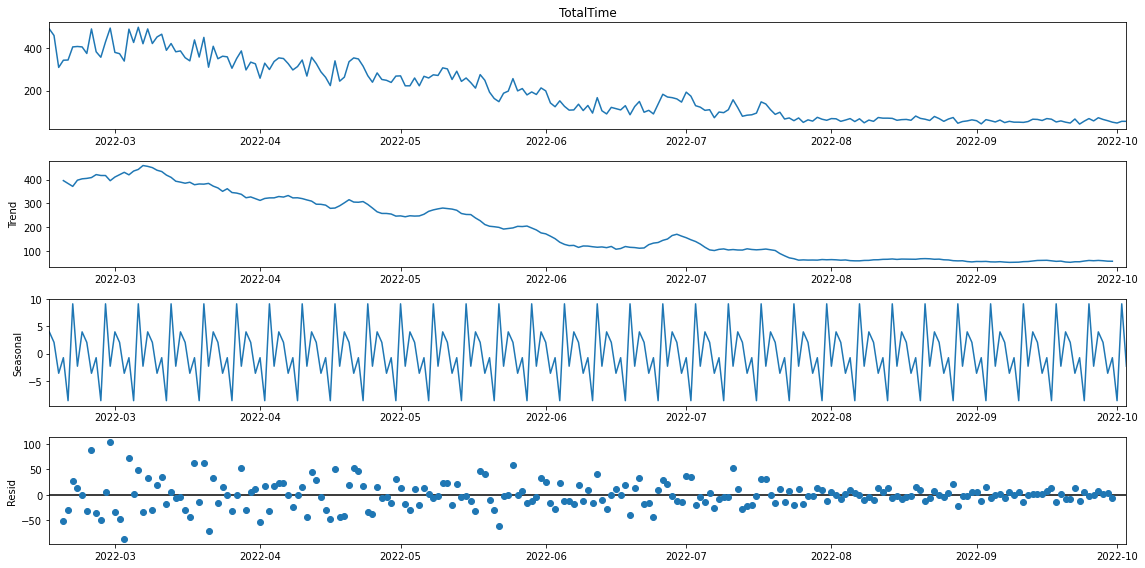

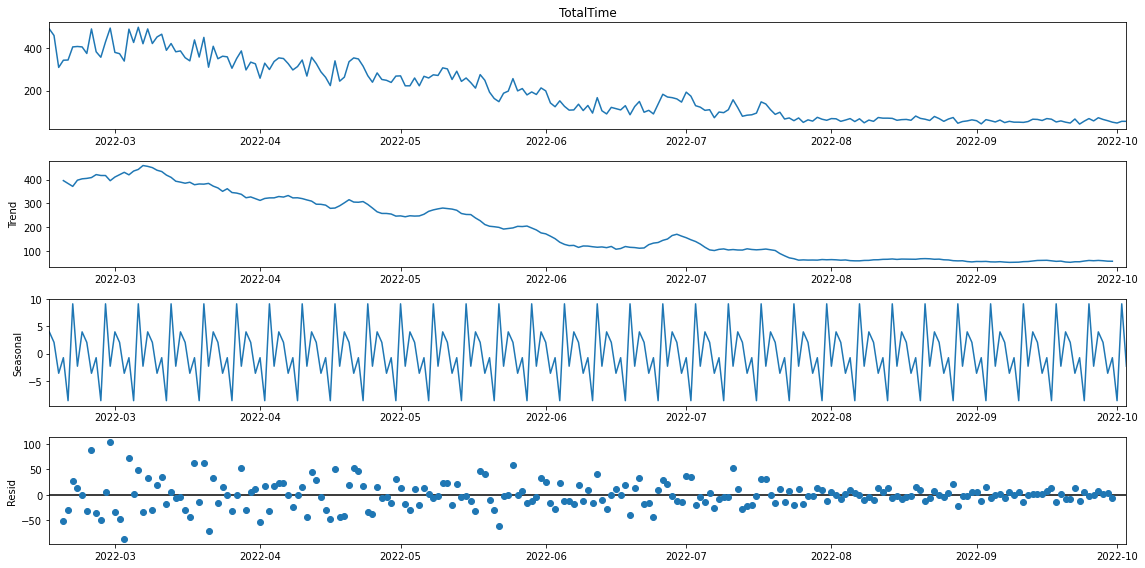

In [35]:
# first chart is observed
# second chart is trend (after removing noise and seasonality from data)
# third chart is seasonal
# values remaining after incorporating trend and seasonality
result.plot()

In [36]:
# creating an multiplicative model
result2 = seasonal_decompose(decomp_df['TotalTime'], model = 'multiplicative')

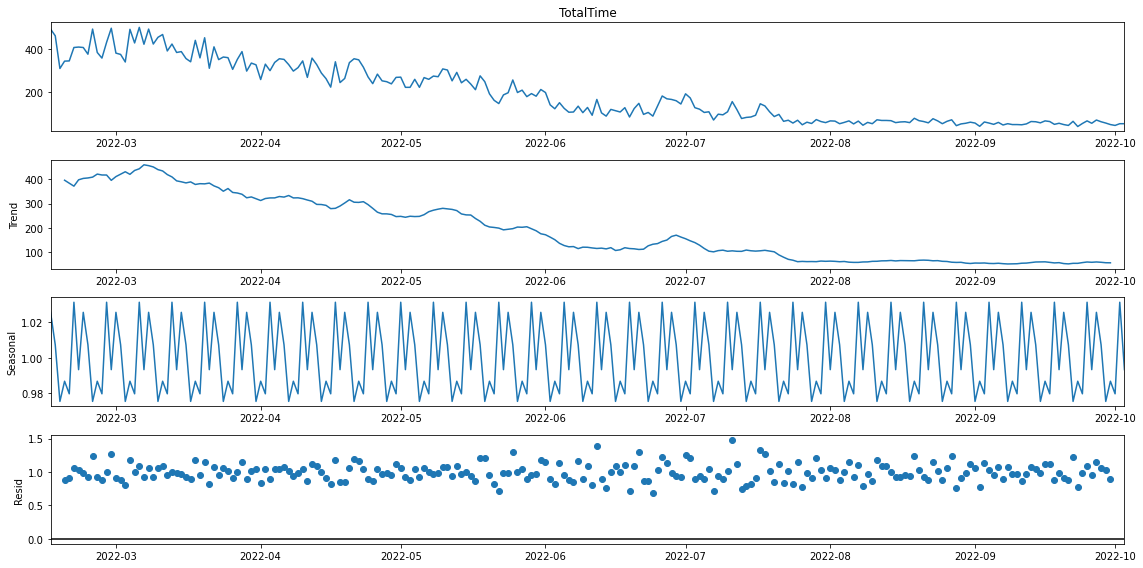

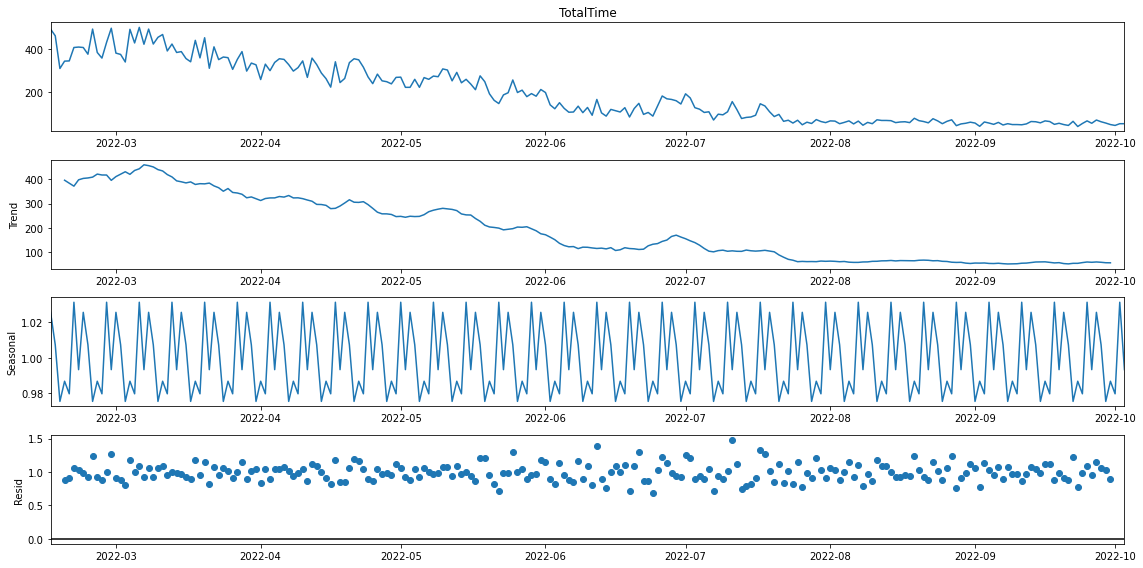

In [37]:
result2.plot()

# Differencing

In [38]:
# create new dataframe called decomp_df (making a copy of df3)
template_df = df3.copy()

In [39]:
# convert to a standard index (and making Date a normal column)
template_df.reset_index(inplace=True)

In [40]:
# delete 'day' column
del template_df['day']

In [41]:
template_df.head()

,Date,TotalTime
0,2022-02-15,492
1,2022-02-16,461
2,2022-02-17,310
3,2022-02-18,344
4,2022-02-19,345


In [42]:
diff_df = template_df.copy()

In [43]:
# creating a lag column
diff_df['lag1'] = diff_df['TotalTime'].shift(1)

In [44]:
diff_df.head()

,Date,TotalTime,lag1
0,2022-02-15,492,NaN
1,2022-02-16,461,492.0
2,2022-02-17,310,461.0
3,2022-02-18,344,310.0
4,2022-02-19,345,344.0


In [45]:
# minusing lag1 from TotalTime to get TotalTime difference
diff_df['TotalTime_diff_1'] = diff_df['TotalTime'].diff(periods=1)

In [46]:
diff_df.head()

,Date,TotalTime,lag1,TotalTime_diff_1
0,2022-02-15,492,NaN,NaN
1,2022-02-16,461,492.0,-31.0
2,2022-02-17,310,461.0,-151.0
3,2022-02-18,344,310.0,34.0
4,2022-02-19,345,344.0,1.0


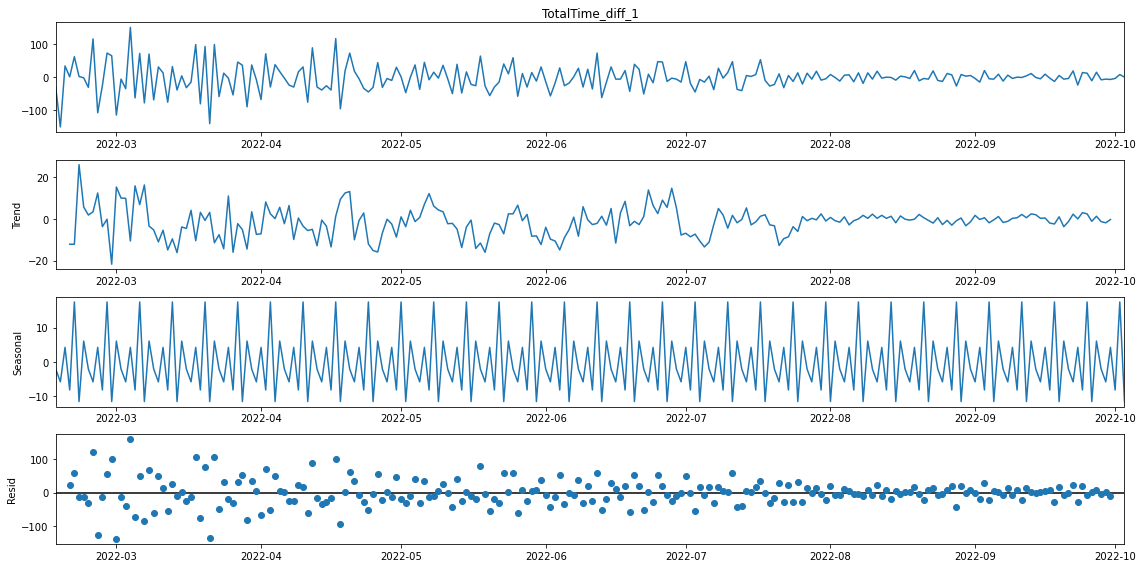

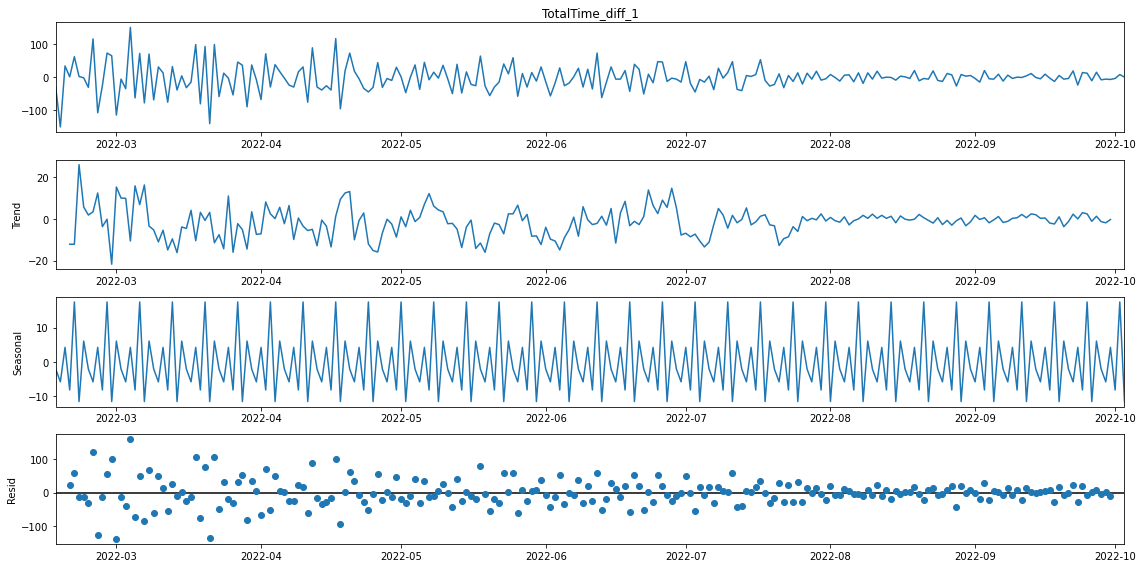

In [47]:
# iloc to segment the dataset to not include Nan first record from TotalTime_diff_1
# removing trend from data using lag differencing
diff_df.index = diff_df['Date']
result_a = seasonal_decompose(diff_df.iloc[1:,3], model='additive')
result_a.plot()

In [48]:
# remove seasonality with lag (not sure if this is relevant as data does not span a year/isn't seasonal?)
diff_df['TotalTime_diff_12'] = diff_df['TotalTime_diff_1'].diff(periods=12)

<AxesSubplot:xlabel='Date'>

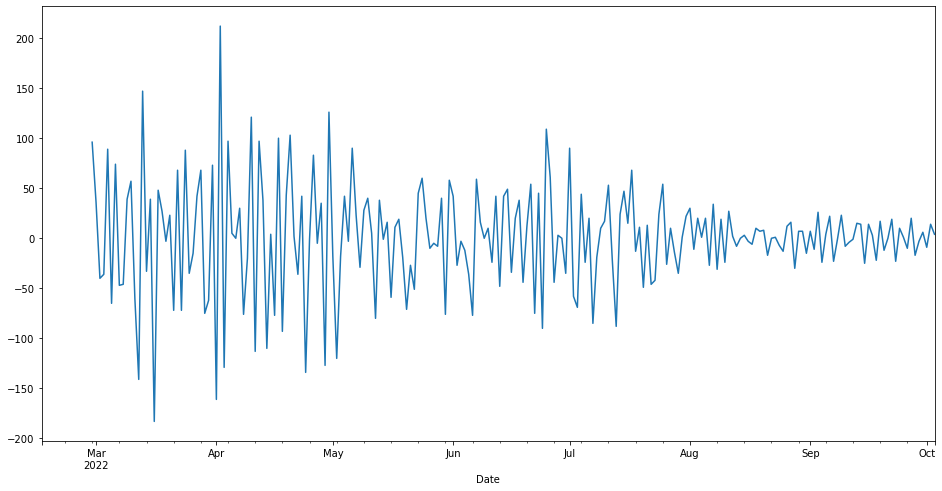

In [49]:
diff_df['TotalTime_diff_12'].plot()

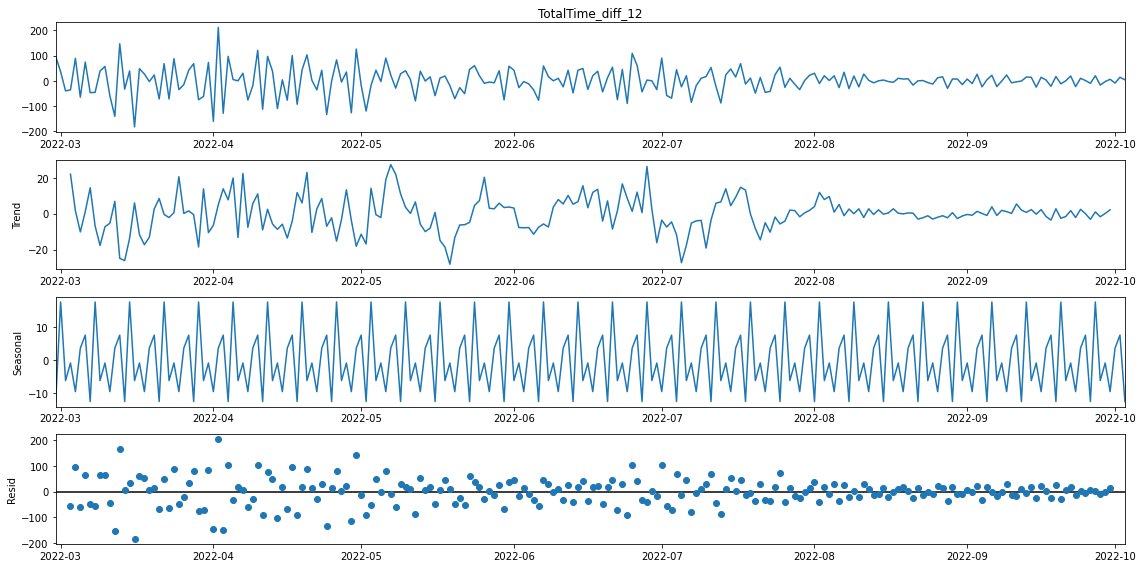

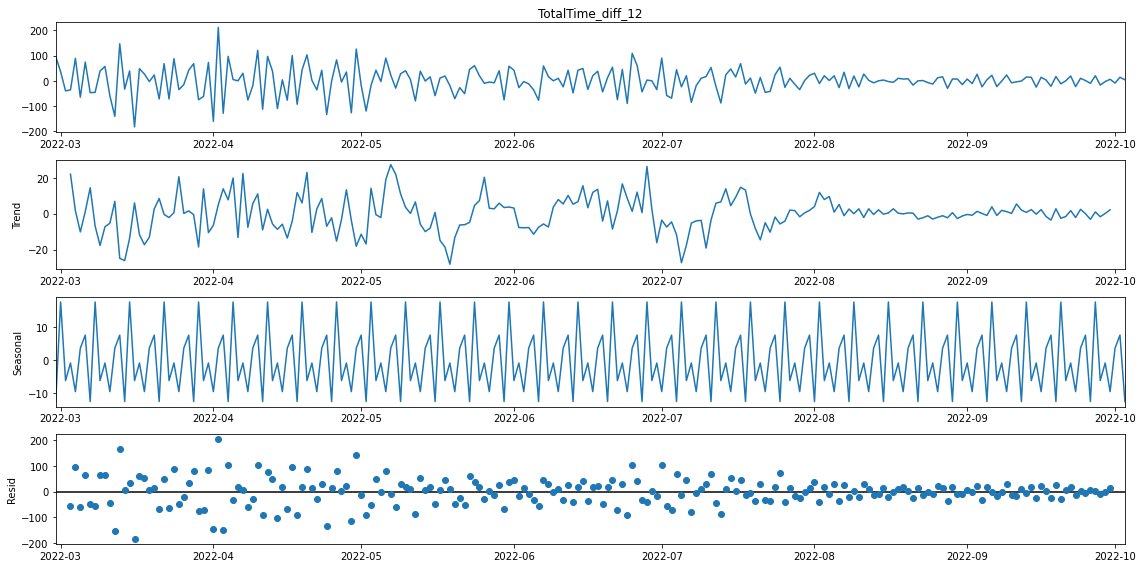

In [50]:
# now no trend and no seasonality
result_b = seasonal_decompose(diff_df.iloc[13:,4], model='additive')
result_b.plot()

# Test Train Split

In [51]:
feed_df = template_df.copy()

In [52]:
# show first 5 records
feed_df.head()

,Date,TotalTime
0,2022-02-15,492
1,2022-02-16,461
2,2022-02-17,310
3,2022-02-18,344
4,2022-02-19,345


In [53]:
#show last 5 records
feed_df.tail()

,Date,TotalTime
226,2022-09-29,58
227,2022-09-30,51
228,2022-10-01,47
229,2022-10-02,55
230,2022-10-03,55


In [54]:
# shows number of rows and number of columns
feed_df.shape

(231, 2)

In [55]:
# total number of rows
feed_df.shape[0]

231

In [56]:
# use 80% of the data as the train set and remaining 20% as a test set
train_size = int(feed_df.shape[0]*0.8)
train_size

184

In [57]:
train = feed_df[0:train_size]

In [58]:
test = feed_df[train_size:]

In [59]:
train.shape

(184, 2)

In [60]:
test.shape

(47, 2)

# Persistence Model

In [61]:
# Naive forecast - last period value is the forecast for the next period

In [62]:
naive_df = template_df.copy()

In [63]:
naive_df.head()

,Date,TotalTime
0,2022-02-15,492
1,2022-02-16,461
2,2022-02-17,310
3,2022-02-18,344
4,2022-02-19,345


In [64]:
# create a lag - the next day's TotalTime should be what it was the previous day
naive_df['t'] = naive_df['TotalTime'].shift(1)

In [65]:
naive_df.head()

,Date,TotalTime,t
0,2022-02-15,492,NaN
1,2022-02-16,461,492.0
2,2022-02-17,310,461.0
3,2022-02-18,344,310.0
4,2022-02-19,345,344.0


In [66]:
train, test = naive_df[1:naive_df.shape[0]-7], naive_df[naive_df.shape[0]-7:]

In [67]:
train.head()

,Date,TotalTime,t
1,2022-02-16,461,492.0
2,2022-02-17,310,461.0
3,2022-02-18,344,310.0
4,2022-02-19,345,344.0
5,2022-02-20,407,345.0


In [68]:
train_x, train_y = train['t'], train['TotalTime']
test_x, test_y = test['t'], test['TotalTime']

In [69]:
# use t values as forecasted
# walk-through validation
predictions = test_x.copy()

In [70]:
print(predictions)
print(test_y)

224    57.0
225    72.0
226    64.0
227    58.0
228    51.0
229    47.0
230    55.0
Name: t, dtype: float64
224    72
225    64
226    58
227    51
228    47
229    55
230    55
Name: TotalTime, dtype: int64


In [71]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, predictions)
mse

64.85714285714286

In [72]:
from matplotlib import pyplot

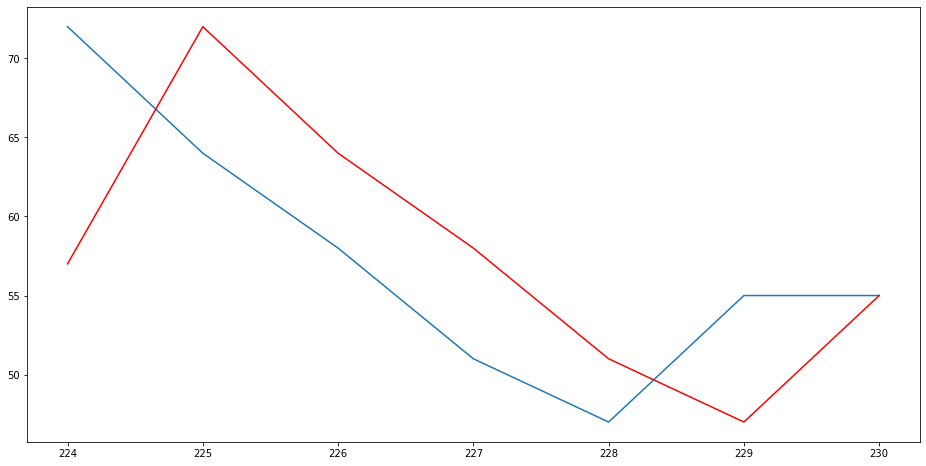

In [73]:
# blue line = actual values, red line = predicted values
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')

# Auto Regression Model

In [74]:
# need to come back to this - couldn't get it to work with my data following the course instructions...

# Moving Average Model

In [75]:
mam_df = template_df.copy()

In [76]:
# create residual values by running naive model first
mam_df['t'] = mam_df['TotalTime'].shift(1)

In [77]:
mam_df.head()

,Date,TotalTime,t
0,2022-02-15,492,NaN
1,2022-02-16,461,492.0
2,2022-02-17,310,461.0
3,2022-02-18,344,310.0
4,2022-02-19,345,344.0


In [78]:
# residual values = Total time - lag(t) value
mam_df['Resid'] = mam_df['TotalTime'] - mam_df['t']

In [79]:
# TotalTime = actual values, t = predicted values, Resid = difference between actual and predicted values
mam_df.head()

,Date,TotalTime,t,Resid
0,2022-02-15,492,NaN,NaN
1,2022-02-16,461,492.0,-31.0
2,2022-02-17,310,461.0,-151.0
3,2022-02-18,344,310.0,34.0
4,2022-02-19,345,344.0,1.0


In [80]:
train, test = mam_df.Resid[1:mam_df.shape[0]-7], mam_df.Resid[mam_df.shape[0]-7:]

In [81]:
train.head()

1    -31.0
2   -151.0
3     34.0
4      1.0
5     62.0
Name: Resid, dtype: float64

In [82]:
# run auto-regression on the residual values
from statsmodels.tsa.ar_model import AR

In [83]:
# train data as an input to the model
model = AR(train)
model_fit = model.fit()

C:\Users\Chloe\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


In [84]:
# how many lag values are important for this autoregression
model_fit.k_ar

15

In [85]:
# coefficient of all these variables
model_fit.params

const       -5.864744
L1.Resid    -0.646743
L2.Resid    -0.281785
L3.Resid    -0.336899
L4.Resid    -0.289909
L5.Resid    -0.114912
L6.Resid    -0.200041
L7.Resid    -0.165166
L8.Resid    -0.054223
L9.Resid    -0.112262
L10.Resid   -0.071975
L11.Resid   -0.099966
L12.Resid   -0.129228
L13.Resid   -0.097022
L14.Resid    0.038342
L15.Resid   -0.056348
dtype: float64

In [86]:
# predict / forecast the residual values
pred_resid = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

In [87]:
# forecasted values (t) + forecasted residual values
predictions = mam_df.t[mam_df.shape[0]-7:] + pred_resid

In [88]:
# forecasted values from moving average model
predictions

224    58.161120
225    59.663705
226    67.276794
227    58.023165
228    44.616641
229    48.742965
230    51.480099
dtype: float64

In [89]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, predictions)
mse

57.56034261809861

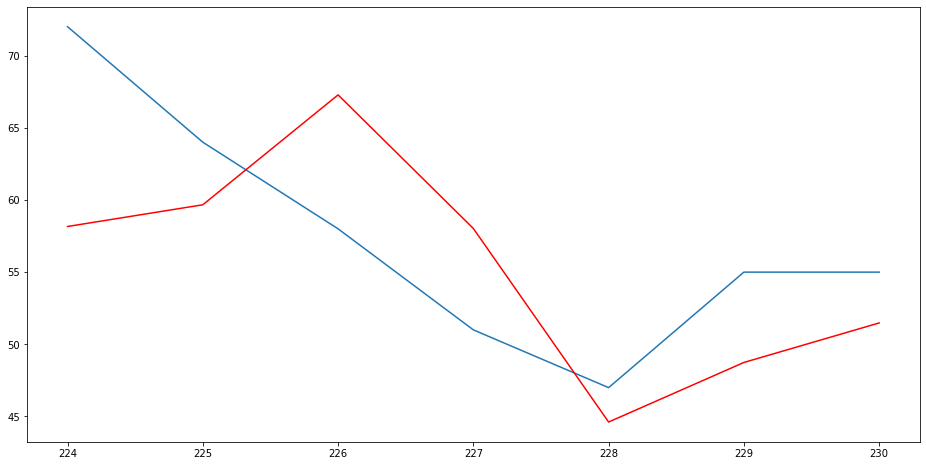

In [90]:
# mse value slightly better than naive value of 369
# blue line is actual, red line is forecast
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')

# ARIMA Model

In [91]:
# Auto Regression Integrated Moving Average (integrated to handle trend, SARIMA to handle seasonality)
# use differencing to remove trend, use AR to forecast, use MA on residuals to update forecast, add trend and seasonality
# to get forecasted value

In [92]:
arima_df = df3.copy()

In [93]:
arima_df.head()

,TotalTime,day
Date,,
2022-02-15,492,0
2022-02-16,461,1
2022-02-17,310,2
2022-02-18,344,3
2022-02-19,345,4


<AxesSubplot:xlabel='Date'>

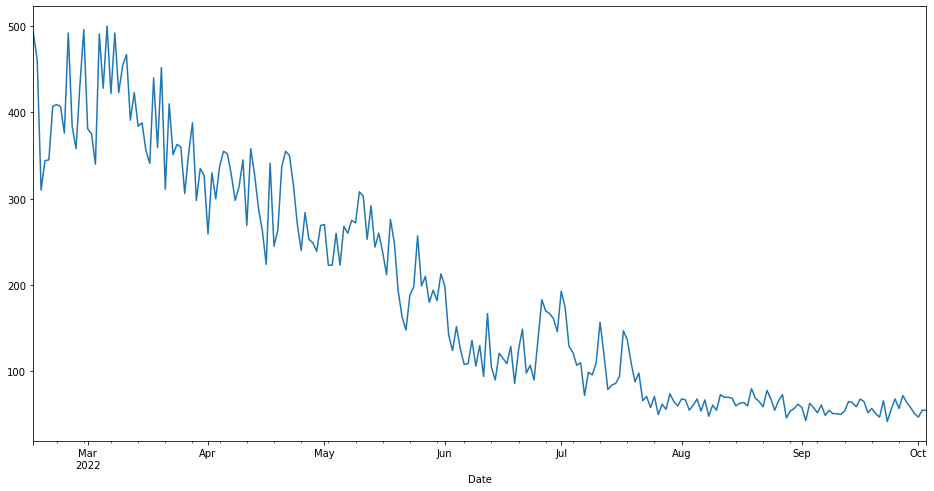

In [94]:
arima_df['TotalTime'].plot()

In [95]:
# trend is polynominal? D = 2?
# next step to plot auto-correlation plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

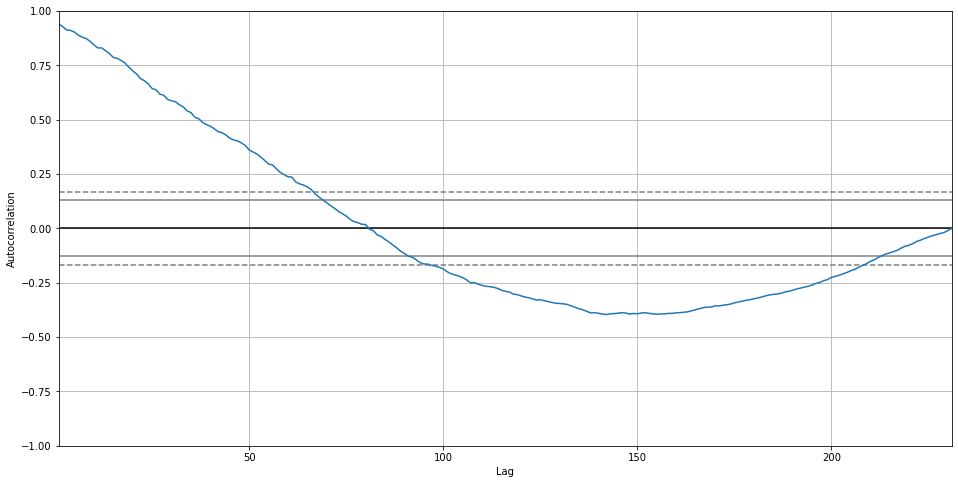

In [96]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(arima_df['TotalTime'])

In [97]:
# q = 2 (the value where the line first crosses the grey confidence interval line)
# next plot the auto correlation graph

In [98]:
from statsmodels.graphics.tsaplots import plot_pacf

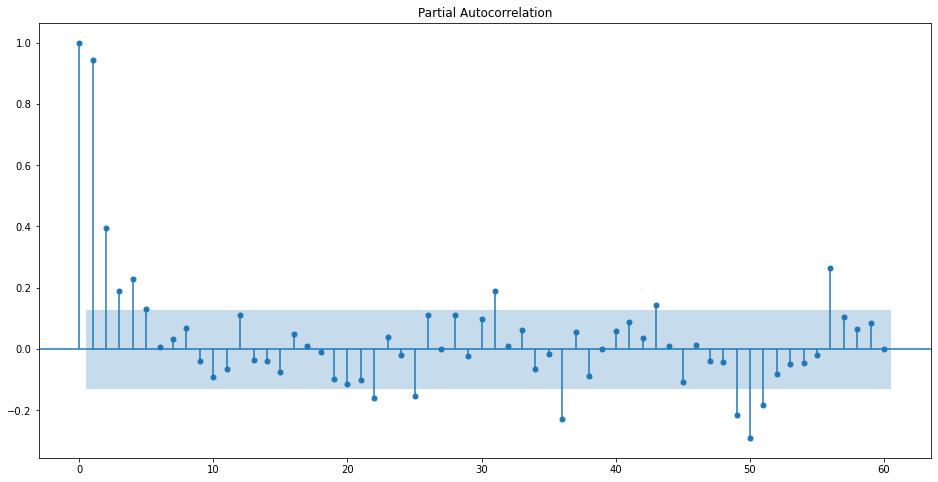

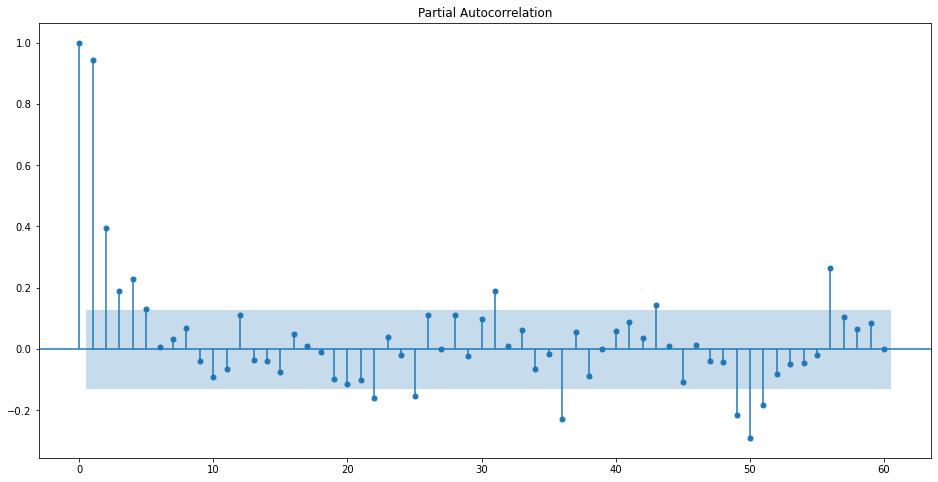

In [99]:
plot_pacf(arima_df['TotalTime'], lags=60)

In [100]:
# blue band in chart above is the confidence interval. Partial autocorrelation is crossing the confidence interval at 
# value 5 (between 4 and 5. Don't count first one as that is not a lag)
# q=5

In [101]:
from statsmodels.tsa.arima_model import ARIMA

In [102]:
model = ARIMA(arima_df['TotalTime'], order= (2,2,5))
# order is P, D, Q

C:\Users\Chloe\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Chloe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D wil

In [103]:
model_fit = model.fit()

In [104]:
model_fit.summary()
# shows coeffienct values

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.TotalTime   No. Observations:                  229
Model:                 ARIMA(2, 2, 5)   Log Likelihood               -1132.305
Method:                       css-mle   S.D. of innovations             33.304
Date:                Tue, 04 Oct 2022   AIC                           2282.609
Time:                        14:52:39   BIC                           2313.513
Sample:                    02-17-2022   HQIC                          2295.077
                         - 10-03-2022                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0106      0.008      1.253      0.210      -0.006       0.027
ar.L1.D2.TotalTime    -0.7124      0.282     -2.524      0.012      -1.266      -0.159
ar.L2.D2.TotalTime    -0.5889      0.277     -2.123      0.034      -1.133      -0.045
ma.L1.D2.TotalTime    -0.9374      0.287     -3.267      0.001      -1.500      -0.375
ma.L2.D2.TotalTime     0.0745      0.439      0.170      0.865      -0.786       0.936
ma.L3.D2.TotalTime    -0.7158      0.382     -1.875      0.061      -1.464       0.033
ma.L4.D2.TotalTime     0.5161      0.180      2.863      0.004       0.163       0.869
ma.L5.D2.TotalTime     0.0626      0.105      0.594      0.553      -0.144       0.269
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6048           -1.1542j            1.3031           -0.3268
AR.2           -0.6048           +1.1542j            1.3031            0.3268
MA.1           -0.5074           -1.0424j            1.1593           -0.3221
MA.2           -0.5074           +1.0424j            1.1593            0.3221
MA.3            1.0000           -0.0000j            1.0000           -0.0000
MA.4            1.2534           -0.0000j            1.2534           -0.0000
MA.5           -9.4874           -0.0000j            9.4874           -0.5000
-----------------------------------------------------------------------------
"""

In [105]:
residuals = model_fit.resid

<AxesSubplot:xlabel='Date'>

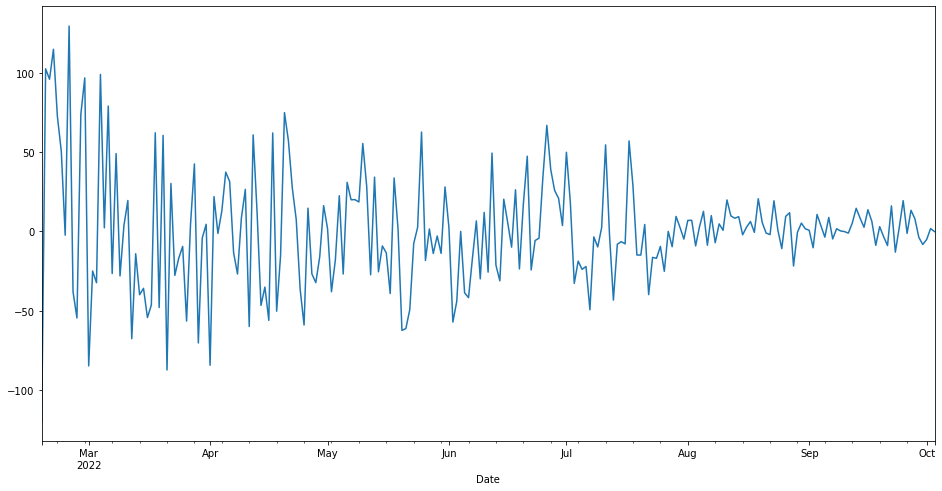

In [106]:
residuals.plot()
# white noise - should be no pattern, else need to improve model

In [107]:
residuals.describe()

count    229.000000
mean       0.404358
std       36.070558
min     -120.010581
25%      -17.810082
50%        0.099647
75%       14.735345
max      129.782945
dtype: float64

In [108]:
# Variations
# ARIMA - model=ARIMA(arima_df['TotalTime'], order=(q,d,p))
# Auto regression - model=ARIMA(arima_df['TotalTime'], order=(q,d,0))
# Moving Average Model - model=ARIMA(arima_df['TotalTime'], order=(0,d,p))

In [109]:
train = arima_df.TotalTime[:173]
test = arima_df.TotalTime[173:]

In [110]:
output = model_fit.forecast()
# gives output for next periods

In [111]:
output
# first number below is forecast value (followed by standard dev, 95% confidence interval for forecast value)

(array([53.00795432]),
 array([33.30372845]),
 array([[-12.26615399, 118.28206264]]))

In [112]:
model_fit.forecast(30)
# figures for the next five periods

(array([53.00795432, 52.71283639, 53.0889443 , 52.09883618, 51.7075082 ,
        51.71856617, 51.1146838 , 50.73625344, 50.58371852, 50.16183518,
        49.82314801, 49.60816995, 49.28041778, 48.9845002 , 48.75667058,
        48.4859388 , 48.23002237, 48.01316887, 47.78411334, 47.56509631,
        47.37046511, 47.17690088, 46.99256619, 46.82537918, 46.66489193,
        46.51388421, 46.37652879, 46.24821596, 46.12977218, 46.02332347]),
 array([33.30372845, 35.28734853, 37.28309531, 37.6499234 , 38.44524255,
        39.71753499, 40.31522456, 41.06321163, 42.03167349, 42.71618835,
        43.43927562, 44.26184587, 44.96183397, 45.66274545, 46.40559912,
        47.09297182, 47.77107516, 48.4641633 , 49.12988368, 49.78502365,
        50.44289891, 51.08535155, 51.71825335, 52.34859914, 52.96875927,
        53.58070023, 54.18800962, 54.7875821 , 55.38005921, 55.96727041]),
 array([[-12.26615399, 118.28206264],
        [-16.44909585, 121.87476863],
        [-19.98457974, 126.16246833],
      

C:\Users\Chloe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


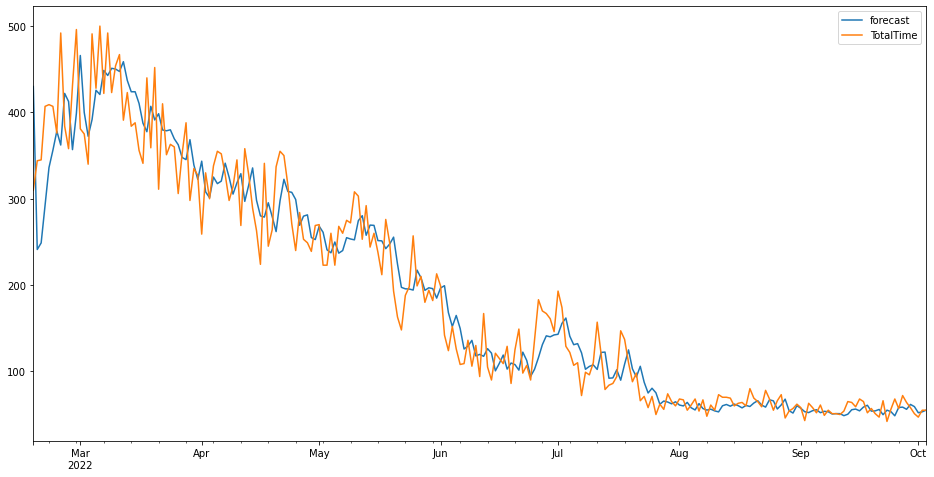

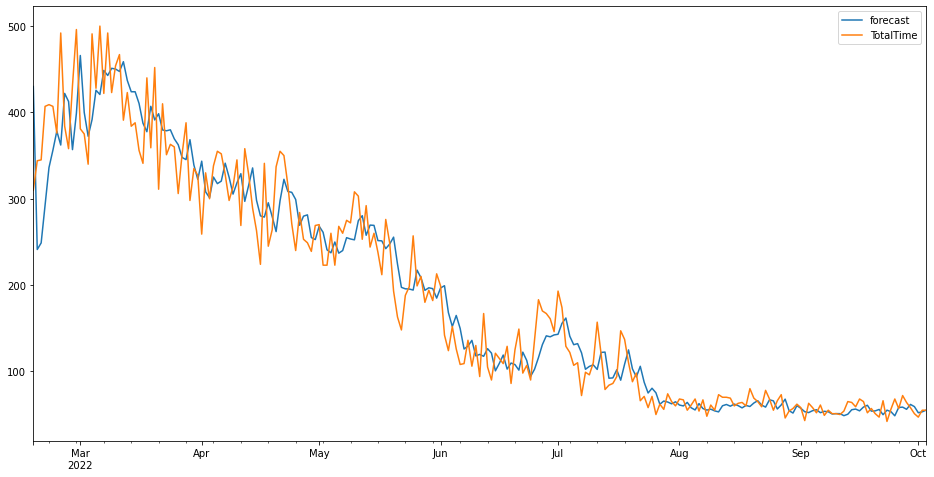

In [113]:
model_fit.plot_predict(dynamic=False)
plt.show(0)
# actual v fitted

C:\Users\Chloe\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Chloe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D wil

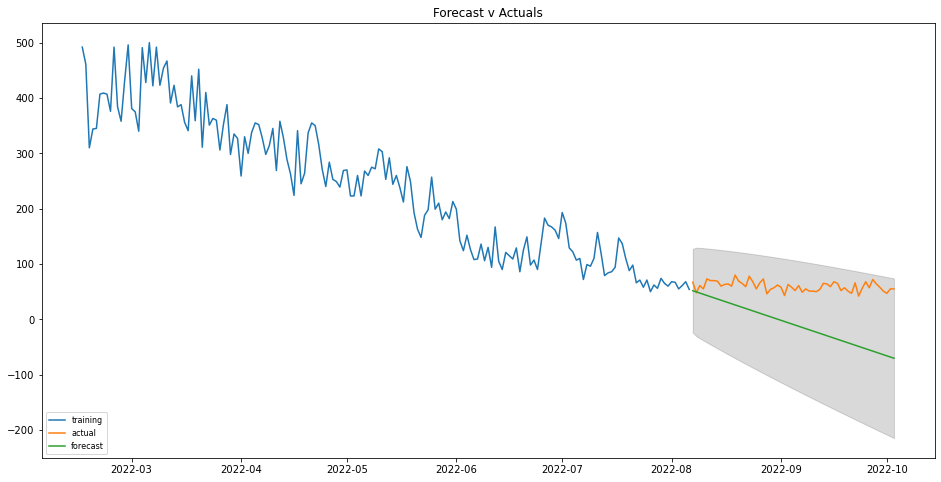

In [114]:
model = ARIMA(train, order=(1,1,1))
fitted = model.fit(disp=-1)

fc, se, conf = fitted.forecast(58, alpha=0.05)

fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:,0], index=test.index)
upper_series = pd.Series(conf[:,1], index=test.index)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast v Actuals')
plt.legend(loc='lower left', fontsize=8)
plt.show()

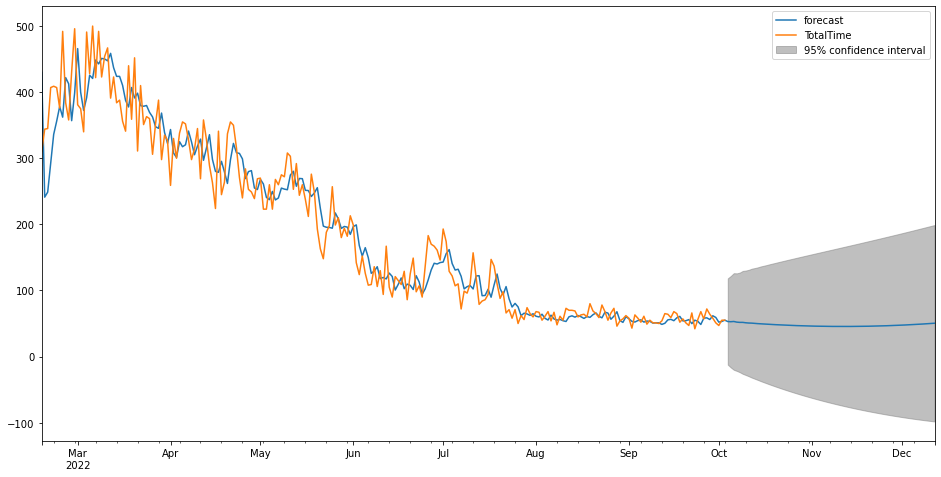

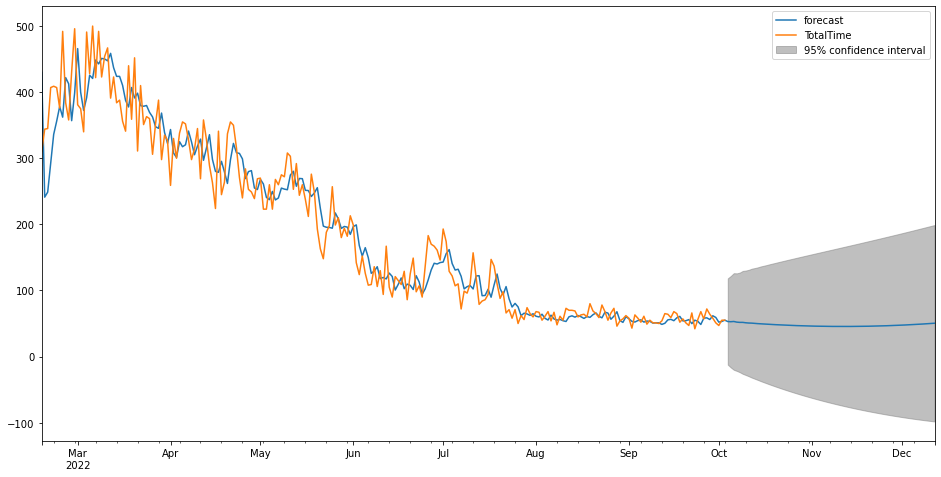

In [115]:
model_fit.plot_predict(2,300)